In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import RNN

from math import sqrt
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]

    X = X.reshape(X.shape[0], 1, X.shape[1])
    print("X", X)
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'accuracy'])
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
        print(model.evaluate())
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


Using TensorFlow backend.


In [16]:

# load dataset
series = read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
train

array([[   0. , -120.1],
       [-120.1,   37.2],
       [  37.2,  -63.8],
       [ -63.8,   61. ],
       [  61. ,  -11.8],
       [ -11.8,   63.3],
       [  63.3,   -7.3],
       [  -7.3,  -31.7],
       [ -31.7,  -69.9],
       [ -69.9,  213.6],
       [ 213.6, -150.6],
       [-150.6,    8.4],
       [   8.4,  -44.8],
       [ -44.8,   60.6],
       [  60.6,   63.2],
       [  63.2,  -81.9],
       [ -81.9,   95.6],
       [  95.6,  -61. ],
       [ -61. ,   77.6],
       [  77.6,  -13.7],
       [ -13.7,  131.7],
       [ 131.7, -157.1],
       [-157.1,   77.8]])

In [3]:

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
train_scaled

array([[-0.15241435, -0.80037766],
       [-0.80037766,  0.04828702],
       [ 0.04828702, -0.496628  ],
       [-0.496628  ,  0.17669274],
       [ 0.17669274, -0.21607769],
       [-0.21607769,  0.1891017 ],
       [ 0.1891017 , -0.1917993 ],
       [-0.1917993 , -0.32344214],
       [-0.32344214, -0.52953871],
       [-0.52953871,  1.        ],
       [ 1.        , -0.96493121],
       [-0.96493121, -0.10709469],
       [-0.10709469, -0.39411923],
       [-0.39411923,  0.17453466],
       [ 0.17453466,  0.18856218],
       [ 0.18856218, -0.59428109],
       [-0.59428109,  0.3633666 ],
       [ 0.3633666 , -0.48152145],
       [-0.48152145,  0.26625303],
       [ 0.26625303, -0.22632857],
       [-0.22632857,  0.55813326],
       [ 0.55813326, -1.        ],
       [-1.        ,  0.26733207]])

In [24]:
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ModelCheckpoint
import logging 

import keras
from sklearn.metrics import roc_auc_score
 
class ResetState(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        pass
 
    def on_train_end(self, logs={}):
        pass
 
    def on_epoch_begin(self, epoch, logs={}):
        return
 
    def on_epoch_end(self, epoch, logs={}):
        pass
 
    def on_batch_begin(self, batch, logs={}):
        pass
 
    def on_batch_end(self, batch, logs={}):
        self.model.reset_states()
#         print("reset model state")
        return
    
earlystop = EarlyStopping(monitor='val_loss',
                          patience=1000,
                          verbose=1,
                          mode='auto')
reset_state = ResetState()
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    epoch = 0
    callbacks = [
        earlystop,
        reset_state
    ]
    X, y = train[:, 0:-1], train[:, -1]

    X = X.reshape(X.shape[0], 1, X.shape[1])
#     print("X", X)
    model = Sequential()
                                                # batch size, time_steps, data_dim
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc', 'mse' ])
#     while earlystop.stopped_epoch == 0:
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,  
              callbacks=callbacks)
#         print("epoch", epoch,  model.history.history.get("loss")[-1])
#         epoch += 1
    return model

X, y = train[:, 0:-1], train[:, -1]

X = X.reshape(X.shape[0], 1, X.shape[1])
X.shape[1], X.shape[2]

(1, 1)

In [30]:
X, y = train[:, 0:-1], train[:, -1]
print(X.shape[0], X.shape[1])
print(X)
X = X.reshape(X.shape[0], 1, X.shape[1])
X

23 1
[[   0. ]
 [-120.1]
 [  37.2]
 [ -63.8]
 [  61. ]
 [ -11.8]
 [  63.3]
 [  -7.3]
 [ -31.7]
 [ -69.9]
 [ 213.6]
 [-150.6]
 [   8.4]
 [ -44.8]
 [  60.6]
 [  63.2]
 [ -81.9]
 [  95.6]
 [ -61. ]
 [  77.6]
 [ -13.7]
 [ 131.7]
 [-157.1]]


array([[[   0. ]],

       [[-120.1]],

       [[  37.2]],

       [[ -63.8]],

       [[  61. ]],

       [[ -11.8]],

       [[  63.3]],

       [[  -7.3]],

       [[ -31.7]],

       [[ -69.9]],

       [[ 213.6]],

       [[-150.6]],

       [[   8.4]],

       [[ -44.8]],

       [[  60.6]],

       [[  63.2]],

       [[ -81.9]],

       [[  95.6]],

       [[ -61. ]],

       [[  77.6]],

       [[ -13.7]],

       [[ 131.7]],

       [[-157.1]]])

In [39]:
import numpy as np

data_dim = 3
timesteps = 2
num_classes = 10

x_train = np.random.random((1000, timesteps, data_dim))
y_train = np.random.random((1000, num_classes))
x_train

array([[[0.23742304, 0.52194116, 0.72264266],
        [0.44935059, 0.73673709, 0.06990145]],

       [[0.69440555, 0.22356274, 0.8782029 ],
        [0.2070233 , 0.19340162, 0.51538323]],

       [[0.61229086, 0.91805906, 0.16913388],
        [0.25195517, 0.62448112, 0.49355185]],

       ...,

       [[0.28012062, 0.34386957, 0.77474482],
        [0.74505344, 0.44301294, 0.04301606]],

       [[0.93565316, 0.12371532, 0.7058655 ],
        [0.76775782, 0.38293313, 0.89692612]],

       [[0.05606994, 0.19828843, 0.70035897],
        [0.99030709, 0.41207613, 0.1312103 ]]])

In [17]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
# lstm_model.predict(train_reshaped, batch_size=1)


Epoch 1/3000
23/23 [==============================] - 1s 42ms/step - loss: 0.2654 - acc: 0.0000e+00 - mean_squared_error: 0.2654
Epoch 2/3000
23/23 [==============================] - 0s 3ms/step - loss: 0.2606 - acc: 0.0000e+00 - mean_squared_error: 0.2606
Epoch 3/3000
23/23 [==============================] - 0s 2ms/step - loss: 0.2565 - acc: 0.0000e+00 - mean_squared_error: 0.2565
Epoch 4/3000
23/23 [==============================] - 0s 2ms/step - loss: 0.2526 - acc: 0.0000e+00 - mean_squared_error: 0.2526
Epoch 5/3000
23/23 [==============================] - 0s 2ms/step - loss: 0.2490 - acc: 0.0000e+00 - mean_squared_error: 0.2490
Epoch 6/3000


/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: mean_squared_error,acc,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


23/23 [==============================] - 0s 3ms/step - loss: 0.2456 - acc: 0.0000e+00 - mean_squared_error: 0.2456
Epoch 7/3000
23/23 [==============================] - 0s 2ms/step - loss: 0.2424 - acc: 0.0000e+00 - mean_squared_error: 0.2424
Epoch 8/3000
23/23 [==============================] - 0s 2ms/step - loss: 0.2393 - acc: 0.0000e+00 - mean_squared_error: 0.2393
Epoch 9/3000
23/23 [==============================] - 0s 2ms/step - loss: 0.2364 - acc: 0.0000e+00 - mean_squared_error: 0.2364
Epoch 10/3000
23/23 [==============================] - 0s 3ms/step - loss: 0.2335 - acc: 0.0000e+00 - mean_squared_error: 0.2335
Epoch 11/3000
23/23 [==============================] - 0s 2ms/step - loss: 0.2306 - acc: 0.0000e+00 - mean_squared_error: 0.2306
Epoch 12/3000
23/23 [==============================] - 0s 2ms/step - loss: 0.2279 - acc: 0.0000e+00 - mean_squared_error: 0.2279
Epoch 13/3000
23/23 [==============================] - 0s 2ms/step - loss: 0.2251 - acc: 0.0000e+00 - mean_squared

KeyboardInterrupt: 

In [7]:
lstm_model.history.history.get("acc")

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,
 0.043478260869565216,

In [14]:

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=1, Predicted=283.254168, Expected=339.700000
Month=2, Predicted=250.909539, Expected=440.400000
Month=3, Predicted=343.823845, Expected=315.900000
Month=4, Predicted=129.941431, Expected=439.300000
Month=5, Predicted=268.620053, Expected=401.300000
Month=6, Predicted=216.183576, Expected=437.400000
Month=7, Predicted=268.840729, Expected=575.500000
Month=8, Predicted=465.126026, Expected=407.600000
Month=9, Predicted=243.417638, Expected=682.000000
Month=10, Predicted=683.967605, Expected=475.300000
Month=11, Predicted=409.241285, Expected=581.300000
Month=12, Predicted=572.481560, Expected=646.900000


Test RMSE: 218.041


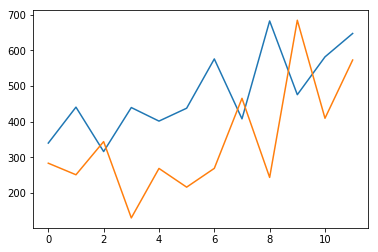

In [15]:

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

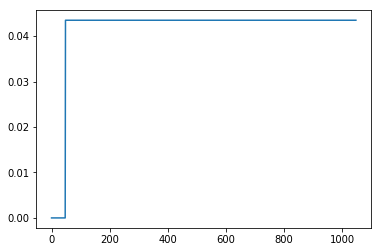

In [11]:
pyplot.plot(lstm_model.history.history.get("acc"))
pyplot.show()